In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle as pkl
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import WeightedRandomSampler, RandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef
from sage.all import *

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")
    
torch.manual_seed(0)
np.random.seed(0)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DTYPE = torch.long

GPU: NVIDIA GeForce RTX 4080 Laptop GPU is available.


In [ ]:
#Generate LEF_data.csv (slow)
EC_FNAME = "ECQ6ap1e4.txt"
COLS = ['conductor', 'hash', 'disc', 'ainvs', 'rank', 'torsion', 'cm', 'aps']
COLS_TO_GET = ['ainvs', 'conductor', 'rank', 'aps']
CONDUCTOR = 1e6
N_APS = prime_pi(200)

def get_data(fname=EC_FNAME, min_cond=0, max_cond=CONDUCTOR, nrows=None):
    df = pd.read_table(fname, sep=':',header=None,names=COLS, nrows=nrows)
    df = df[(df['conductor'] < max_cond)]
    df = df[COLS_TO_GET]
    df['aps'] = df['aps'].apply(eval)
    df['aps'] = df['aps'].apply(lambda x: x[:N_APS]) 
    for i, p in enumerate(primes_first_n(N_APS)):
        df[str(p)] = df['aps'].apply(lambda x: x[i])
    df = df.drop('aps', axis = 1)
    return df

%time df = get_data()
df.head(5)

In [ ]:
#Save data (E with N_E < 1e6, a_q with q < 200)
df.to_csv('LEF_data.csv', index=False) 

In [2]:
#Load data (E with N_E < 1e6, a_q with q < 200)
df = pd.read_csv('LEF_data.csv')
df

,ainvs,conductor,rank,2,3,5,7,11,13,17,...,157,163,167,173,179,181,191,193,197,199
0,"[0,-1,1,0,0]",11,0.0,-2,-1,1,-2,1,4,-2,...,-7,4,-12,-6,-15,7,17,4,-2,0
1,"[1,0,1,-11,12]",14,0.0,-1,-2,0,1,0,-4,6,...,-4,-16,-12,-12,-12,20,24,14,-18,20
2,"[1,1,1,0,0]",15,0.0,-1,-1,1,0,-4,-2,2,...,14,-4,0,-18,20,-10,16,2,6,-8
3,"[1,-1,1,-91,-310]",17,0.0,-1,0,-2,4,0,-2,1,...,-2,24,-4,22,12,-2,-16,2,-18,-20
4,"[0,1,1,1,0]",19,0.0,0,-2,3,-1,3,-4,-3,...,14,20,-18,-18,-18,2,3,-4,18,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3607207,"[1,-1,1,1381,5618]",999999,0.0,-1,0,2,-1,-1,-1,1,...,16,-11,6,-4,4,0,17,-20,12,-7
3607208,"[0,0,1,270,-60865]",999999,1.0,0,0,0,-1,-1,1,-1,...,-10,-6,-8,0,-1,-12,21,-17,-2,-5
3607209,"[0,0,1,30,2254]",999999,1.0,0,0,0,-1,1,1,1,...,-10,-6,8,0,1,-12,-21,-17,2,-5
3607210,"[1,-1,0,14700,55223]",999999,1.0,1,0,4,1,-1,-1,-3,...,0,-2,8,-24,-13,-24,-3,-27,5,-20


In [3]:
#Extract data for a specific experiment (e.g. p = 2, \ell_p = 2, \ell_q = 2)
#Reduction type
r_type = 'good'
#Prime we want to predict
p = 2
#Upperbound on primes used as features
q_max = 100
#How we reduce the predicting prime (use None to not reduce)
ell_p = None
#How we reduce the features (use None not to reduce)
ell_q = None

if r_type == 'good':
    df = df[df['conductor'] % p != 0]
elif r_type == 'bad':
    df = df[df['conductor'] % p == 0]

primes = [str(q) for q in primes_first_n(prime_pi(q_max))]
df = df[primes]

for q in primes_first_n(prime_pi(q_max)):
    if q == p and ell_p is not None:
        df[str(q)] = df[str(q)] % ell_p
    elif q !=p and ell_q is not None:
        df[str(q)] = df[str(q)] % ell_q

df

,2,3,5,7,11,13,17,19,23,29,...,53,59,61,67,71,73,79,83,89,97
0,-2,-1,1,-2,1,4,-2,0,-1,0,...,-6,5,12,-7,-3,4,-10,-6,15,-7
2,-1,-1,1,0,-4,-2,2,4,0,-2,...,-10,-4,-2,12,-8,10,0,12,-6,2
3,-1,0,-2,4,0,-2,1,-4,4,6,...,6,-12,-10,4,-4,-6,12,-4,10,2
4,0,-2,3,-1,3,-4,-3,1,0,6,...,12,-6,-1,-4,6,-7,8,12,12,8
6,-1,1,-2,-1,4,-2,-6,4,0,-2,...,6,12,-2,4,0,-6,-16,-12,-14,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3607207,-1,0,2,-1,-1,-1,1,5,-1,0,...,0,9,4,12,15,-4,7,-9,-7,-8
3607208,0,0,0,-1,-1,1,-1,-8,-3,4,...,10,8,-10,4,0,1,-1,-14,-12,13
3607209,0,0,0,-1,1,1,1,-8,3,-4,...,-10,-8,-10,4,0,1,-1,14,12,13
3607210,1,0,4,1,-1,-1,-3,6,0,-4,...,-4,0,-10,9,6,15,4,0,10,6


In [4]:
#Count and remove duplicates
duplicates = df.duplicated(keep = 'first')
print(sum(duplicates))
df = df.drop_duplicates()

0


In [5]:
#Count indeterminacy
df0, df1 = df[df[str(p)] ==  0], df[df[str(p)] ==  1]
df0, df1 = df0.drop_duplicates(), df1.drop_duplicates()
primes = [str(q) for q in primes_first_n(prime_pi(q_max)) if q != p]
df0, df1 = df0[primes], df1[primes]
combined_df = pd.concat([df0, df1])
duplicates = combined_df.duplicated(subset = primes, keep = 'first')
print(sum(duplicates))

0


In [6]:
class MyDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
    def __len__(self):
        return len(self.features)
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

#Return data in the form [num_datapoints, num_features, num_classes]
def ints_to_one_hot_raw(features, q_max):
    min_val = -2 * int(np.ceil(q_max**0.5))
    max_val = 2 * int(np.ceil(q_max**0.5))
    shifted_features = features - min_val
    one_hot_encodings = torch.nn.functional.one_hot(shifted_features, num_classes=(max_val - min_val + 1))
    one_hot_encodings = one_hot_encodings.view(features.shape[0], features.shape[1], -1)
    return one_hot_encodings

def ints_to_one_hot_mod(features, ell):
    min_val = 0
    max_val = ell-1
    shifted_features = features - min_val
    one_hot_encodings = torch.nn.functional.one_hot(shifted_features, num_classes=(max_val - min_val + 1))
    one_hot_encodings = one_hot_encodings.view(features.shape[0], features.shape[1], -1)    
    return one_hot_encodings
    
def create_data_set(df, pred_p = p, ell_p = ell_p, ell_q = ell_q):
    features = df[[str(q) for q in primes_first_n(prime_pi(q_max)) if q != pred_p]].values
    labels = df[str(pred_p)].values
    features = torch.tensor(features, dtype=torch.long) 
    labels = torch.reshape(torch.tensor(labels, dtype=torch.long), (len(labels), 1))
    if ell_q is not None:
        features = ints_to_one_hot_mod(features, ell_q)
    else:
        features = ints_to_one_hot_raw(features, q_max)
    if ell_p is not None:
        labels = ints_to_one_hot_mod(labels, ell_p)
        labels = torch.reshape(labels, (len(labels), ell_p))
    else:
        labels = ints_to_one_hot_raw(labels, pred_p)
        num_classes = 4 * int(np.ceil(pred_p**0.5)) + 1
        labels = torch.reshape(labels, (len(labels), num_classes))
    return MyDataset(features.to(torch.float32), labels.to(torch.float32))

class CustomNeuralNetwork(nn.Module):
    def __init__(self, input_shape, output_size, hidden_layers):
        super(CustomNeuralNetwork, self).__init__()
        
        self.flatten = nn.Flatten()
        input_size = input_shape[0] * input_shape[1]        
        self.input_layer = nn.Linear(input_size, hidden_layers[0])
        
        self.hidden_layers = nn.ModuleList()
        for i in range(1, len(hidden_layers)):
            self.hidden_layers.append(nn.Linear(hidden_layers[i-1], hidden_layers[i]))
        
        self.output_layer = nn.Linear(hidden_layers[-1], output_size)
    
    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.input_layer(x))
        for layer in self.hidden_layers:
            x = F.relu(layer(x))
        x = self.output_layer(x)
        return x

In [7]:
#Split into train and test data
n_samples = min([2 * 10**6, len(df)])
print('Number of sample:', n_samples)
test_size = 1e4/n_samples
df = df.sample(n=n_samples, replace=False)
df_train, df_test = train_test_split(df, test_size=test_size, shuffle = False)
combined_df = pd.concat([df_train, df_test])
duplicates = combined_df.duplicated(keep = False)
train_dataset = create_data_set(df_train, p)
test_dataset = create_data_set(df_test, p)

Number of sample: 732205


In [30]:
#Train the model
#Experiment a.1
#p = 2, q_max = 100, ell_p = None, ell_q = None, n_samples = 732205

BATCH_SIZE = 1024
NUM_EPOCHS = 1000

sampler = RandomSampler(train_dataset)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler = sampler, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

input_size = train_dataset.features[0].shape
hidden_layers = [128, 64, 32]
output_size = train_dataset.labels[0].shape[0]
dropout_prob = 0.2

model = CustomNeuralNetwork(input_size, output_size, hidden_layers).to('cuda')
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('Number of trainable parameters:', params)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.1)
best_acc = 0
best_mcc = 0

train_losses, val_losses, train_accs, val_accs, train_mccs, val_mccs = [], [], [], [], [], []
for epoch in range(NUM_EPOCHS):
    # Training loop
    num_correct, total = 0, 0
    loss_total, batch_count = 0, 0
    mcc_total = 0
    for i, (data, targets) in enumerate(train_loader):
        data = data.to('cuda')        
        targets = targets.to('cuda') 
        
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss_total += loss.item()
        batch_count += 1

        predictions = torch.argmax(outputs, axis=1)
        expected = torch.argmax(targets, axis=1)
        num_correct += (predictions == expected).sum()
        total += targets.size(0)

        mcc_total += matthews_corrcoef(predictions.cpu(), expected.cpu()) 

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_losses.append(loss_total/batch_count)
    train_accs.append(num_correct/total)
    train_mccs.append(mcc_total/batch_count)
        
    # Testing loop
    mcc_total = 0
    num_correct, total = 0, 0
    loss_total, batch_count = 0, 0
    
    model.eval()
    with torch.no_grad():
        num_correct, total = 0, 0
        loss_total, batch_count = 0, 0
        for i, (data, targets) in enumerate(test_loader):
            data = data.to('cuda')         
            targets = targets.to('cuda') 
            
            outputs = model(data)
            loss = criterion(outputs, targets)
            loss_total += loss.item()
            batch_count += 1
    
            predictions = torch.argmax(outputs, axis=1)
            expected = torch.argmax(targets, axis=1)
            num_correct += (predictions == expected).sum()
            total += targets.size(0)

            mcc_total += matthews_corrcoef(predictions.cpu(), expected.cpu()) 
            
    val_losses.append(loss_total/batch_count)
    val_accs.append(num_correct/total)
    val_mccs.append(mcc_total/batch_count)
    if val_accs[-1] > best_acc: best_acc = val_accs[-1]
    if val_mccs[-1] > best_mcc: best_mcc = val_mccs[-1]
    print(f'Epoch [{epoch + 1}/{NUM_EPOCHS}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {val_losses[-1]:.4f}, Train Acc: {train_accs[-1]*100:.2f}, Test Acc: {val_accs[-1]*100:.2f}, Train MCC: {train_mccs[-1]:.2f}, Test MCC: {val_mccs[-1]:.2f}')

print('Highest accuracy: ', best_acc)
print('Highest mcc: ', best_mcc)

Number of trainable parameters: 136713
Epoch [1/500], Train Loss: 1.5802, Test Loss: 1.4253, Train Acc: 28.10, Test Acc: 32.40, Train MCC: 0.08, Test MCC: 0.16
Epoch [2/500], Train Loss: 1.4037, Test Loss: 1.3791, Train Acc: 32.44, Test Acc: 33.21, Train MCC: 0.15, Test MCC: 0.14
Epoch [3/500], Train Loss: 1.3769, Test Loss: 1.3677, Train Acc: 33.60, Test Acc: 33.65, Train MCC: 0.14, Test MCC: 0.14
Epoch [4/500], Train Loss: 1.3692, Test Loss: 1.3643, Train Acc: 34.16, Test Acc: 33.94, Train MCC: 0.14, Test MCC: 0.14
Epoch [5/500], Train Loss: 1.3655, Test Loss: 1.3613, Train Acc: 34.29, Test Acc: 34.53, Train MCC: 0.14, Test MCC: 0.14
Epoch [6/500], Train Loss: 1.3631, Test Loss: 1.3595, Train Acc: 34.48, Test Acc: 34.47, Train MCC: 0.14, Test MCC: 0.15
Epoch [7/500], Train Loss: 1.3606, Test Loss: 1.3577, Train Acc: 34.61, Test Acc: 34.54, Train MCC: 0.14, Test MCC: 0.14
Epoch [8/500], Train Loss: 1.3583, Test Loss: 1.3550, Train Acc: 34.79, Test Acc: 34.91, Train MCC: 0.15, Test MCC

In [32]:
#Save model with TorchScript
model_scripted = torch.jit.script(model) 
model_scripted.save('model_a1.pt')

In [37]:
model = torch.jit.load('model_a1.pt')

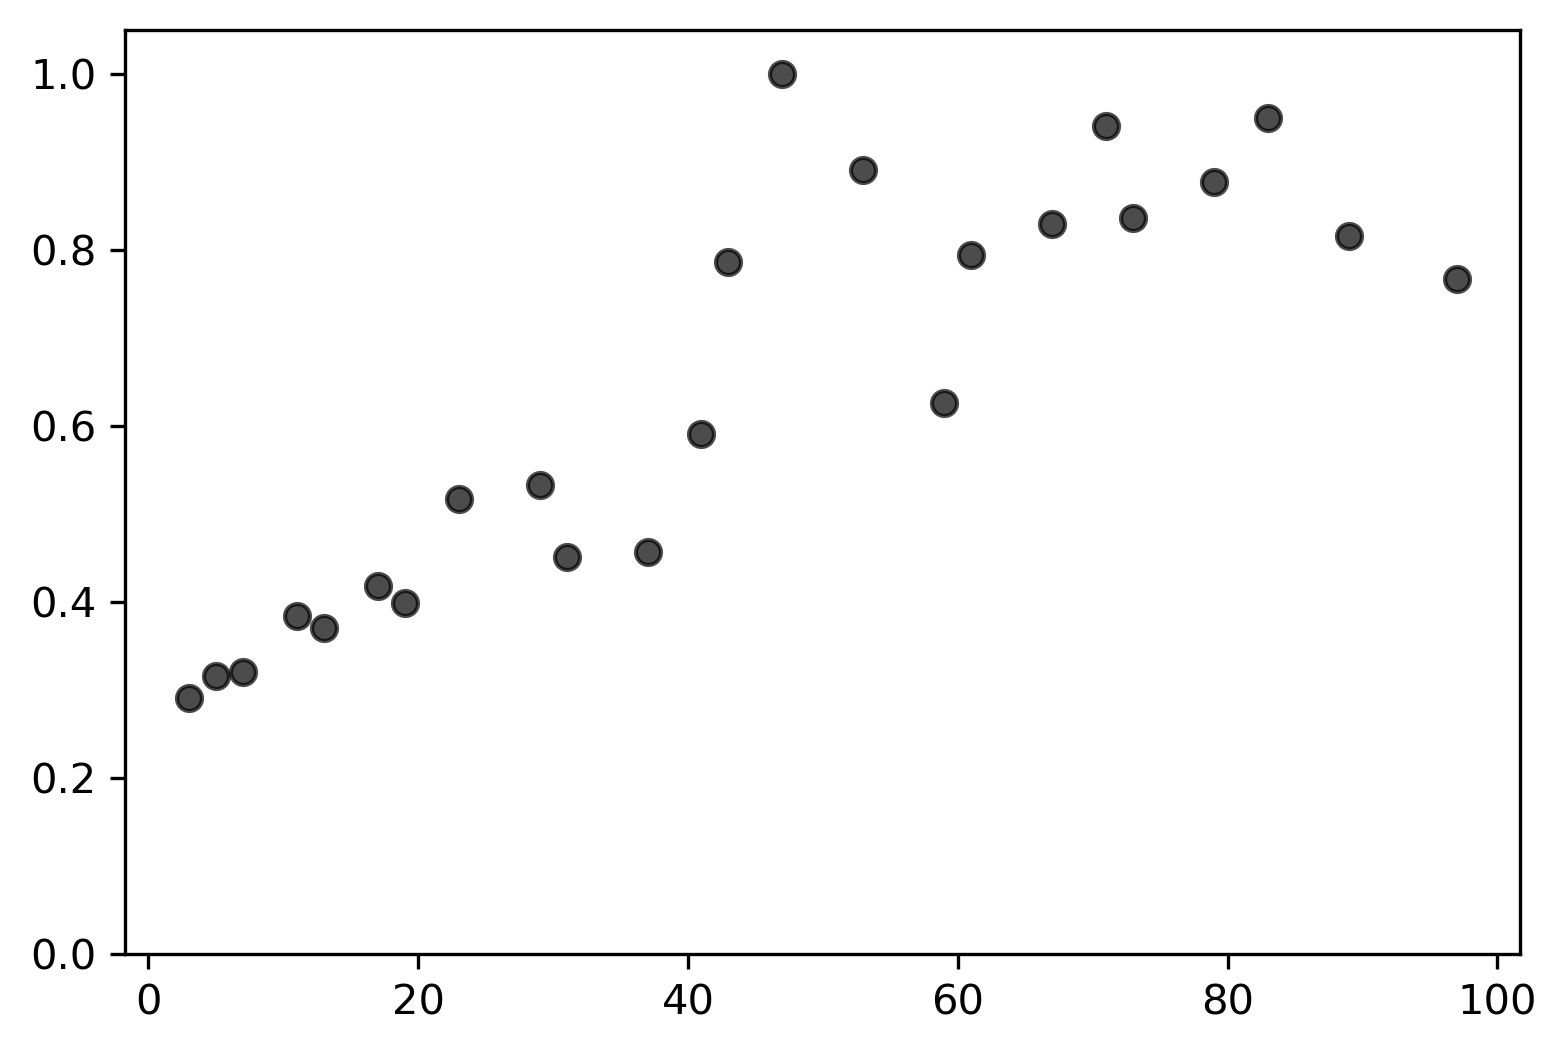

In [38]:
primes = [q for q in primes_first_n(prime_pi(q_max)) if q != p]
saliency = torch.tensor(24,)

for data, targets in test_loader:
    data = data.to('cuda')  # Move data to GPU
    data.requires_grad = True  # Enable gradient computation
    # Forward pass
    output = model(data)
    # If output has multiple elements, take the sum to compute gradients properly
    output = output.sum()
    # Compute the gradient of the output w.r.t. the input
    output.backward()
    # Get absolute values of the gradients
    saliency = data.grad.abs().detach().cpu().numpy()[0]  
    saliency = torch.mean(torch.tensor(saliency), axis = 1)

plt.figure(dpi=300, figsize=(6,4))
saliency = saliency/torch.max(saliency)
# Scatter plot of saliency values
plt.scatter(primes, saliency, color='black', alpha=0.7)
plt.ylim((0,1.05))
# plt.xlabel("Prime")
# plt.ylabel("Saliency")
# plt.title("Saliency Map")
plt.show()

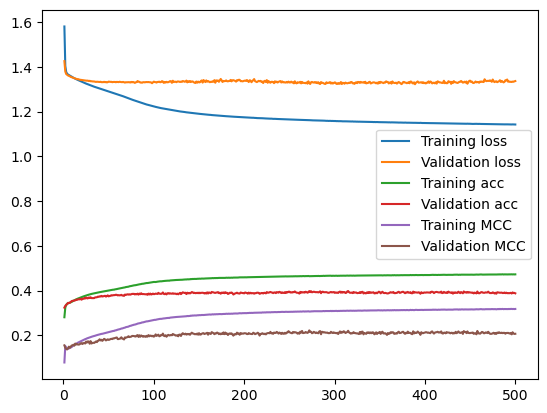

In [36]:
#Plot training history
x_axis = list(range(1,NUM_EPOCHS+1))
plt.plot(x_axis, train_losses, label='Training loss')
plt.plot(x_axis, val_losses, label ='Validation loss')
plt.plot(x_axis, [train_acc.tolist() for train_acc in train_accs], label = 'Training acc')
plt.plot(x_axis, [val_acc.tolist() for val_acc in val_accs], label = 'Validation acc')
plt.plot(x_axis, [train_mcc.tolist() for train_mcc in train_mccs], label = 'Training MCC')
plt.plot(x_axis, [val_mcc.tolist() for val_mcc in val_mccs], label = 'Validation MCC')
plt.legend()
plt.show()